In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy
import time

from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from matplotlib import cm
# from unwrap import unwrap

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from utils.data import *

In [3]:
# first implementation, slow
def gen_pattern(a, b, r_spacing=3):
    M_c = int(256/2)  # center of kspace
    N_c = int(192/2)  # center of kspace
    n = math.floor(M_c/r_spacing)  # number of regions
    p_pattern = np.zeros((256, 192))
    # generate density of the pattern
    k = 0
    for r_1 in range(0, M_c, r_spacing):
        r_2 = r_1 + r_spacing
        for i in range(256):
            for j in range(192):
                if p_pattern[i, j] != 0:
                    continue
                else:
                    radius = np.sqrt((i - M_c)**2 + (j - N_c)**2)
                    if radius <  r_2 and radius >= r_1:
                        p_pattern[i, j] = np.exp(-(b*k/n)**a)
        k += 1
    # keep the center square for calibration
    p_pattern[M_c-13:M_c+12, N_c-13:N_c+12] = 1
    return p_pattern

In [4]:
# second implementation, fast
def gen_pattern2(a, b, num_row=256, num_col=192, r_spacing=3):
    M_c = int(num_row/2)  # center of kspace
    N_c = int(num_col/2)  # center of kspace
    n = math.floor(M_c/r_spacing)  # number of regions
    p_pattern = np.zeros((num_row, num_col)).flatten()
    indices = np.array(np.meshgrid(range(num_row), range(num_col))).T.reshape(-1,2)  # row first
    distances = np.sqrt((indices[:, 0] - M_c)**2 + (indices[:, 1] - N_c)**2)
    distances_orders = distances // r_spacing  # get the order of the distances
    for k in range(M_c//r_spacing + 1):
        p_pattern[distances_orders == k] = np.exp(-(b*k/n)**a)
    p_pattern = p_pattern.reshape(num_row, num_col)
#     p_pattern[M_c-13:M_c+12, N_c-13:N_c+12] = 1
    return p_pattern

def rescalePmask(Pmask, samplingRatio):
    xbar = np.mean(Pmask)
    r = samplingRatio/xbar
    beta = (1-samplingRatio) / (1-xbar)
    le = (r<=1)
    return le * Pmask * r + (1-le) * (1 - (1-Pmask) * beta)

In [14]:
# third implementation
a = 1.5
b = 10
num_row = 206
num_col = 80
r_spacing = 1
M_c = int(num_row/2)  # center of kspace
N_c = int(num_col/2)  # center of kspace
n = math.floor(M_c/r_spacing)  # number of regions
p_pattern = np.zeros((num_row, num_col)).flatten()
indices = np.array(np.meshgrid(range(num_row), range(num_col))).T.reshape(-1,2)  # row first
distances = np.sqrt((indices[:, 0] - M_c)**2 + (indices[:, 1] - N_c)**2)
distances_orders = distances // r_spacing  # get the order of the distances
distances_orders = distances_orders.reshape(num_row, num_col)
p_pattern = np.exp(-(b*distances_orders/n)**a)

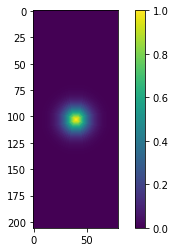

In [15]:
plt.figure()
plt.imshow(p_pattern)
plt.colorbar()

0.0

In [ ]:
t0 = time.time()
p_pattern = gen_pattern(a=10**(-0.124), b=10**(0.386), r_spacing=3)
plt.figure()
plt.imshow(p_pattern)
plt.colorbar()

# np.mean(p_pattern)

print(time.time() - t0)

0.20000000000000004
0.034673213958740234


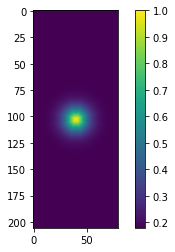

In [5]:
t0 = time.time()
# a=1.5, b=2.92 for 23.77%, a=1.5, b=3.46 for 18.62%, a=1.5, b=4.25 for 13.90%,
p_pattern2 = gen_pattern2(a=1.5, b=10, num_row=206, num_col=80, r_spacing=1)
p_pattern2 = rescalePmask(p_pattern2, 0.2)
plt.figure()
plt.imshow(p_pattern2)
plt.colorbar()

print(np.mean(p_pattern2))

print(time.time() - t0)

0.21674757281553397


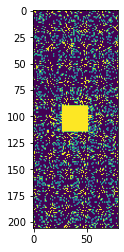

In [12]:
u = np.random.uniform(0, 1, size=(206, 80))
mask2 = p_pattern2>u
mask2[103-13:103+12, 40-13:40+12] = 1
# plt.imshow(np.concatenate((mask, mask2), axis=1))
# print(np.mean(mask), np.mean(mask2))
plt.imshow(mask2)
print(np.mean(mask2))

In [ ]:
writecfl('mask_0.2m', mask2) 

In [ ]:
u = np.random.uniform(0, 1, size=(256, 192))
mask2 = (u > 0.89) * (p_pattern > 0) 
mask2[128-13:128+12, 96-13:96+12] = 1

# Test unwrap function

In [17]:
rootName = '/data/Jinwei/Multi_echo_slice_recon_GE'
iField = load_mat(rootName+'/results/Targets5.mat', varname='Targets')
iField[::2, ...] = - iField[::2, ...]

In [24]:
phase_slice = np.angle(iField[50, :, :, :])
necho = iField.shape[-1]
unwrapped_slice = unwrap(phase_slice, wrap_around_axis_0=True,
                         wrap_around_axis_1=True, wrap_around_axis_2=False)

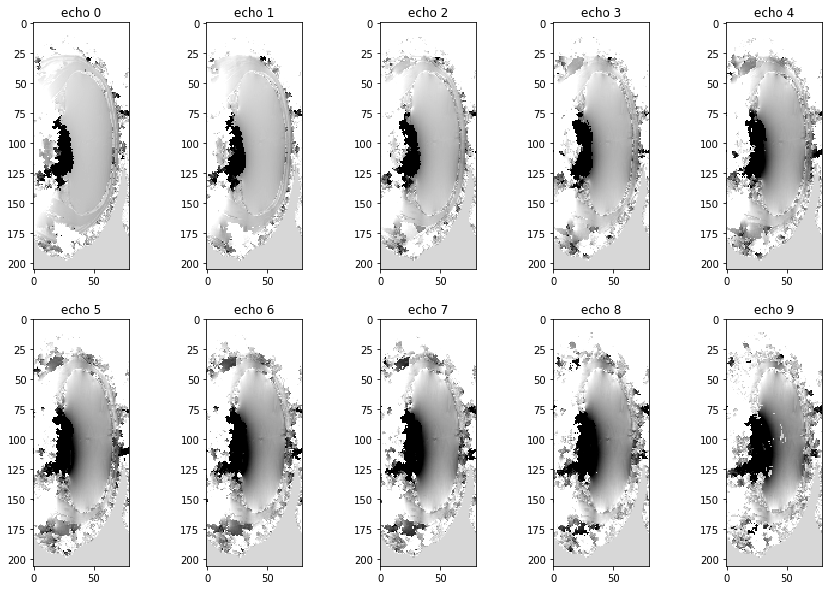

In [25]:
plt.figure(figsize = (15,10))
for i in range(0, necho):
    plt.subplot(2, necho//2, i+1)
    plt.imshow(unwrapped_slice[:, :, i], vmin=-12, vmax=6, cmap='gray')
    plt.title('echo {}'.format(i))

In [ ]:
data, target = make_classification(n_samples=2500,
                                   n_features=45,
                                   n_informative=15,
                                   n_redundant=5)

def sample_loss(params):
    print('C = {0}, gamma = {1}'.format(params[0], params[1]))
    return cross_val_score(SVC(C=10 ** params[0], gamma=10 ** params[1], random_state=12345),
                           X=data, y=target, scoring='roc_auc', cv=3).mean()

In [ ]:
lambdas = np.linspace(1, -4, 25)
gammas = np.linspace(1, -4, 20)

# We need the cartesian combination of these two vectors
param_grid = np.array([[C, gamma] for gamma in gammas for C in lambdas])

# real_loss = [sample_loss(params) for params in param_grid]
real_loss = np.load('real_loss.npy')
# np.save('real_loss.npy', real_loss)

# The maximum is at:
param_grid[np.array(real_loss).argmax(), :]

In [ ]:
C, G = np.meshgrid(lambdas, gammas)
plt.figure()
cp = plt.contourf(C, G, np.array(real_loss).reshape(C.shape), cmap=cm.jet)
plt.colorbar(cp)
plt.title('Filled contours plot of loss function L(gamma, C)')
plt.xlabel('C')
plt.ylabel('gamma')
# plt.savefig('/Users/thomashuijskens/Personal/gp-optimisation/figures/real_loss_contour.png', bbox_inches='tight')
plt.show()

In [ ]:
bounds = np.array([[-4, 1], [-4, 1]])

xp, yp = bayesian_optimisation(n_iters=30, 
                               sample_loss=sample_loss, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=False)

In [ ]:
plot_iteration(lambdas, xp, yp, first_iter=3, second_param_grid=gammas, optimum=[0.375, -2.15789474])

In [7]:
import torch
import matplotlib.pyplot as plt

In [23]:
class CrossEntropyMask(torch.nn.Module):
    def __init__(self, necho=10, nrow=206, ncol=80, radius=30):
        super(CrossEntropyMask, self).__init__()
        self.necho = necho
        self.nrow = nrow
        self.ncol = ncol
        self.non_calib = torch.tensor(self.gen_pattern(radius=radius)).to('cuda')


    def gen_pattern(self, num_row=206, num_col=80, radius=30):
        M_c = int(num_row/2)  # center of kspace
        N_c = int(num_col/2)  # center of kspace
        p_pattern = np.ones((num_row, num_col)).flatten()
        indices = np.array(np.meshgrid(range(num_row), range(num_col))).T.reshape(-1,2)  # row first
        distances = np.sqrt((indices[:, 0] - M_c)**2 * 0.5 + (indices[:, 1] - N_c)**2)
        distances_orders = distances // radius  # get the order of the distances
        p_pattern[distances_orders == 0] = 0
        p_pattern = p_pattern.reshape(num_row, num_col)
        return p_pattern


    def forward(self, pmask):
        loss = 0
        for i in range(self.necho):
            for j in range(self.necho):
                if j == i:
                    continue
                else:
                    a = torch.clamp(pmask[i][self.non_calib==1], min=1e-12, max=1-1e-12)
                    b = pmask[j][self.non_calib==1]
                    loss -= torch.sum(b*torch.log(a+1e-9)) / b.size()[0]
        return loss

In [33]:
cem = CrossEntropyMask(radius=30)
mask = np.asarray(cem.non_calib.cpu().detach())

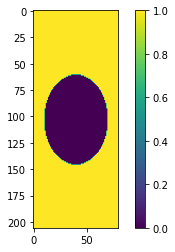

In [34]:
plt.figure()
plt.imshow(mask)
plt.colorbar()

In [32]:
np.mean(mask)

0.5699635922330097